# Ibovespa forecasting using neural networks

## Machine Learning Engineer Nanodegree - Capstone Proposal

### Import python packages

In [12]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.utils.data
from torch import optim
from torch import nn
from torch.autograd import Variable
from ibov.utils import load_config
from ibov.feature import create_lags, consolidate_features
from ibov.model import Ibovespa, train
from ibov.request import get_history, label_train_test

### Loading Configs

In [13]:
# Load config dict
config = load_config()

In [14]:
# Feature Engineering Configs
split = config.get("feature").get("split")
window = config.get("feature").get("window")

# Data Configs
data_dir = config.get("data").get("dir")
ibov_ticker = config.get("ibov").get("ticker")
history_file = config.get("data").get("history")

### Data Preparation

In [68]:
# Invoke yahoo finance api
ibovespa = get_history(ticker=ibov_ticker)

# Save data on disk
ibovespa.to_csv(os.path.join(data_dir, history_file), index=False)

# Label datapoint as train or test dataset
ibovespa = label_train_test(ibovespa, split=split, split_valid=0.1)

### Feature Engineering

In [69]:
# Create lag variables
ibov_lags_df = create_lags(ibovespa, window=window, var="close", index="date")

In [140]:
def create_delta_sign(data, var, index, window):
    
    data = data.copy()
    
    delta_sign = \
        np.reshape([np.sign(i-j) for t in data[var] for i, j in zip(t[:-1], t[1:])], (data.shape[0], window-1))
    
    result = [a+[x] for a,x in zip([l.tolist() for l in delta_sign], [0]*delta_sign.shape[0])]
    
    data["delta_sign"] = result
    
    delta_sign_df = data[[index, "delta_sign"]]  
    
    return delta_sign_df

In [141]:
ibov_delta_sign_df = create_delta_sign(ibov_lags_df, var="lags", index="date", window=window)

In [143]:
# Consolidate raw data with features
master_table = consolidate_features(ibovespa, "date", ibov_lags_df, ibov_delta_sign_df)

### Definição do modelo

In [145]:
variables=["lags", "delta_sign"]

In [149]:
def torch_data(df, target, variables, group_var, batch, group):
    
    data  = df[df[group_var] == group].reset_index()
    
    x_tensor = torch.Tensor(data[variables].values.tolist())
    y_tensor = torch.Tensor(data[target])
    
    dataset = torch.utils.data.TensorDataset(x_tensor,y_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch)
    
    return loader, x_tensor, y_tensor   

In [150]:
train_loader, train_x_tensor, train_y_tensor = \
    torch_data(master_table, target="target", variables=["lags", "delta_sign"], group_var="group", batch=100, group="train")

valid_loader, valid_x_tensor, valid_y_tensor = \
    torch_data(master_table, target="target", variables="lags", group_var="group", batch=100, group="valid")

test_loader, test_x_tensor, test_y_tensor = \
    torch_data(master_table, target="target", variables="lags", group_var="group", batch=100, group="test")

In [151]:
for batch in train_loader:
        # Get training data
        batch_x, batch_y = batch
        print(batch)

[tensor([[[ 4.5292e+04,  4.5340e+04,  4.6265e+04],
         [-1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 4.5340e+04,  4.6265e+04,  4.6590e+04],
         [-1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 4.6265e+04,  4.6590e+04,  4.7264e+04],
         [-1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 4.6590e+04,  4.7264e+04,  4.8551e+04],
         [-1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 4.7264e+04,  4.8551e+04,  4.8553e+04],
         [-1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 4.8551e+04,  4.8553e+04,  4.7364e+04],
         [-1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 4.8553e+04,  4.7364e+04,  4.7282e+04],
         [ 1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 4.7364e+04,  4.7282e+04,  4.6401e+04],
         [ 1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 4.7282e+04,  4.6401e+04,  4.6504e+04],
         [ 1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 4.6401e+04,  4.6504e+04,  4.6657e+04],
         [-1.0000e+00, -1.0000e

[tensor([[[ 6.3937e+04,  6.5160e+04,  6.4811e+04],
         [-1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 6.5160e+04,  6.4811e+04,  6.4829e+04],
         [ 1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 6.4811e+04,  6.4829e+04,  6.4438e+04],
         [-1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 6.4829e+04,  6.4438e+04,  6.4541e+04],
         [ 1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 6.4438e+04,  6.4541e+04,  6.4751e+04],
         [-1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 6.4541e+04,  6.4751e+04,  6.4442e+04],
         [-1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 6.4751e+04,  6.4442e+04,  6.3533e+04],
         [ 1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 6.4442e+04,  6.3533e+04,  6.3605e+04],
         [ 1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 6.3533e+04,  6.3605e+04,  6.3049e+04],
         [-1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 6.3605e+04,  6.3049e+04,  6.1479e+04],
         [ 1.0000e+00,  1.0000e

[tensor([[[ 2.3059e+04,  2.2873e+04,  2.2893e+04],
         [ 1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 2.2873e+04,  2.2893e+04,  2.3411e+04],
         [-1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 2.2893e+04,  2.3411e+04,  2.3368e+04],
         [-1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 2.3411e+04,  2.3368e+04,  2.2959e+04],
         [ 1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 2.3368e+04,  2.2959e+04,  2.3289e+04],
         [ 1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 2.2959e+04,  2.3289e+04,  2.3954e+04],
         [-1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 2.3289e+04,  2.3954e+04,  2.3927e+04],
         [-1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 2.3954e+04,  2.3927e+04,  2.4104e+04],
         [ 1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 2.3927e+04,  2.4104e+04,  2.4027e+04],
         [-1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 2.4104e+04,  2.4027e+04,  2.4205e+04],
         [ 1.0000e+00, -1.0000e

[tensor([[[ 9.1550e+03,  9.0710e+03,  9.1980e+03],
         [ 1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 9.0710e+03,  9.1980e+03,  8.9110e+03],
         [-1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 9.1980e+03,  8.9110e+03,  8.6740e+03],
         [ 1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 8.9110e+03,  8.6740e+03,  8.9530e+03],
         [ 1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 8.6740e+03,  8.9530e+03,  8.9430e+03],
         [-1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 8.9530e+03,  8.9430e+03,  9.0750e+03],
         [ 1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 8.9430e+03,  9.0750e+03,  9.0130e+03],
         [-1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 9.0750e+03,  9.0130e+03,  8.8610e+03],
         [ 1.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 9.0130e+03,  8.8610e+03,  8.9740e+03],
         [ 1.0000e+00, -1.0000e+00,  0.0000e+00]],

        [[ 8.8610e+03,  8.9740e+03,  8.9520e+03],
         [-1.0000e+00,  1.0000e

In [9]:
model = Ibovespa(input_layer=window, hidden_layer=100, dropout=0.215)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training error: 260.70674987630645
validation error: 82.07093961827896


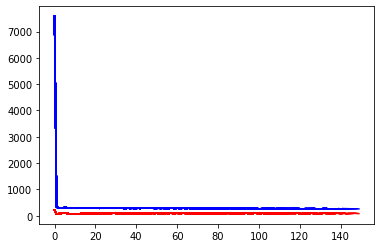

In [10]:
train(model, train_loader, valid_loader, criterion, optimizer, epochs=150)

In [11]:
import seaborn as sns

In [12]:
def evaluate_results(x_tensor, y_tensor):
    # Prediction error
    pred = np.array(np.hstack(model(x_tensor).detach().numpy()).tolist())
    true = np.array(np.hstack(y_tensor).tolist())
    mae = np.mean(np.abs(pred - true))
    # Predict delta accuracy
    delta_true = np.array([1 if np.sign(true[idx]-true[idx+1]) >=0 else 0 for idx in range(true.shape[0]-1)])
    delta_pred = np.array([1 if np.sign(pred[idx]-pred[idx+1]) >=0 else 0 for idx in range(pred.shape[0]-1)])
    tp = sum(1 for val in (delta_true + delta_pred) if val==2)
    fp = sum(1 for val in (delta_true - delta_pred) if val==-1)
    fn = sum(1 for val in (delta_true - delta_pred) if val==1)
    precision = tp/(tp+fp)
    recal = tp/(tp+fn)
    f1 = 2*(precision*recal)/(precision+recal)
    
    return mae, f1

In [13]:
evaluate_results(train_x_tensor, train_y_tensor)

(416.6878456692019, 0.5419070240922973)

In [14]:
evaluate_results(valid_x_tensor, valid_y_tensor)

(691.7044165316046, 0.5465288035450517)

In [15]:
evaluate_results(test_x_tensor, test_y_tensor)

(1253.5029938412408, 0.5013774104683195)

### Benchmark Model

In [16]:
bcm_true = np.array(np.hstack(test_y_tensor).tolist())
bcm_pred = np.array(list(np.array(np.hstack(test_y_tensor).tolist())[1:]) + list(np.array(valid_y_tensor[0])))

In [17]:
mae = np.mean(np.abs(bcm_pred - bcm_true))
# Predict delta accuracy
delta_true = np.array([1 if np.sign(bcm_true[idx]-bcm_true[idx+1]) >=0 else 0 for idx in range(bcm_true.shape[0]-1)])
delta_pred = np.array([1 if np.sign(bcm_pred[idx]-bcm_pred[idx+1]) >=0 else 0 for idx in range(bcm_pred.shape[0]-1)])
tp = sum(1 for val in (delta_true + delta_pred) if val==2)
fp = sum(1 for val in (delta_true - delta_pred) if val==-1)
fn = sum(1 for val in (delta_true - delta_pred) if val==1)
precision = tp/(tp+fp)
recal = tp/(tp+fn)
f1 = 2*(precision*recal)/(precision+recal)

In [18]:
mae, f1

(1172.9620437956205, 0.5013774104683195)

### Graphical Evaluation

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
bcm = pd.DataFrame()
bcm["true"] = bcm_true
bcm["pred"] = bcm_pred

In [21]:
pred = np.array(np.hstack(model(test_x_tensor).detach().numpy()).tolist())
true = np.array(np.hstack(test_y_tensor).tolist())
modelo = pd.DataFrame()
modelo["true"] = true
modelo["pred"] = pred

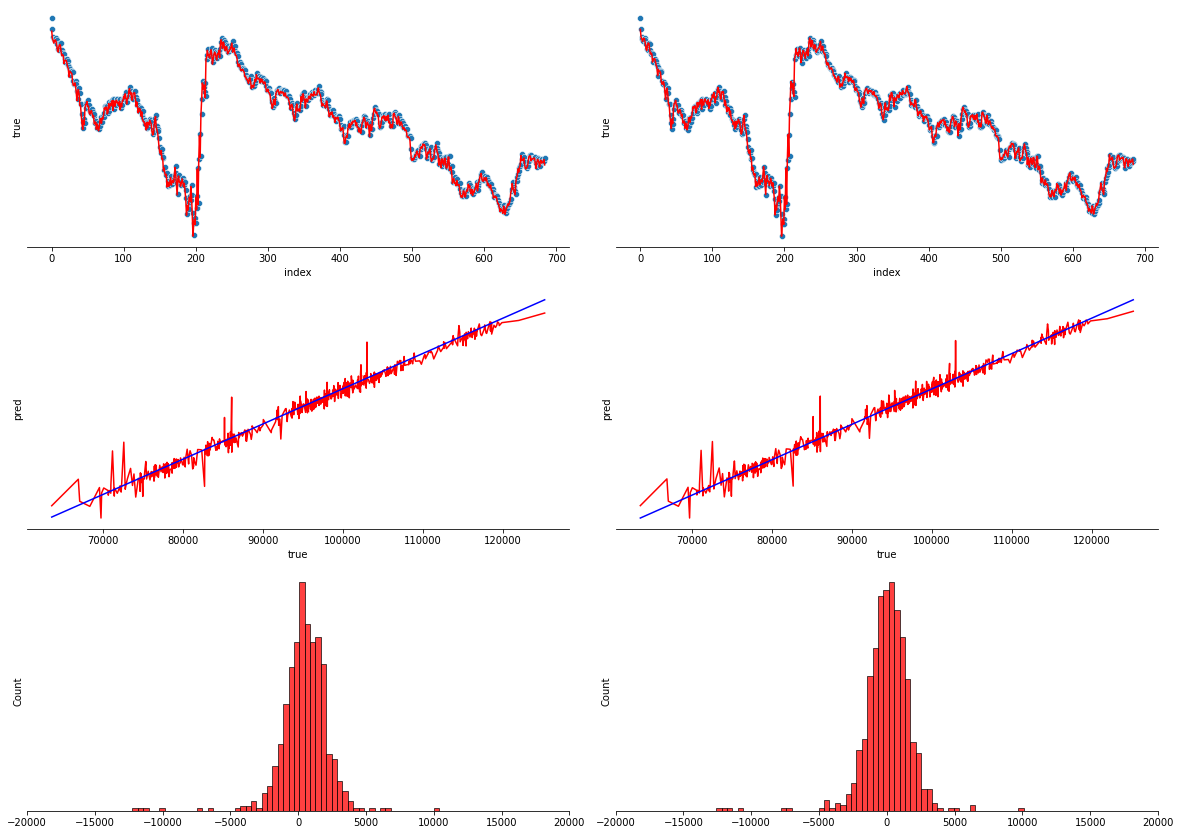

In [22]:
f, axes = plt.subplots(3, 2, figsize=(16.5, 11.7))
sns.despine(left=True)

# Plot a simple distribution of the desired columns
sns.scatterplot(x="index", y='true', data=modelo.reset_index(), ax=axes[0, 0])
sns.lineplot(x="index", y="pred", data=modelo.reset_index(),ax=axes[0, 0], color='r')

sns.scatterplot(x="index", y='true', data=bcm.reset_index(), ax=axes[0, 1])
sns.lineplot(x="index", y="pred", data=bcm.reset_index(),ax=axes[0, 1], color='r')

sns.lineplot(x="true", y="pred", data=modelo.reset_index(),ax=axes[1, 0], color='r')
sns.lineplot(x="true", y="true", data=modelo.reset_index(),ax=axes[1, 0], color='blue')

sns.lineplot(x="true", y="pred", data=bcm.reset_index(),ax=axes[1, 1], color='r')
sns.lineplot(x="true", y="true", data=bcm.reset_index(),ax=axes[1, 1], color='blue')

sns.histplot(data = modelo["true"] - modelo["pred"],ax=axes[2, 0], color='r')
axes[2, 0].set_xlim(-20000, 20000)

sns.histplot(data = bcm["true"] - bcm["pred"],ax=axes[2, 1], color='r')
axes[2, 1].set_xlim(-20000, 20000)

plt.setp(axes, yticks=[])
plt.tight_layout()

### Sagemaker Training

import boto3
import sagemaker

sagemaker_session = sagemaker.Session(boto_session=boto3.session.Session(region_name="sa-east-1"))

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/ibovespa'

try:
    role = sagemaker.get_execution_role()
except Exception as err:
    role = "arn:aws:iam::977053370764:role/service-role/AmazonSageMaker-ExecutionRole-20201202T141643"

data_root_dir

input_data = sagemaker_session.upload_data(path=data_root_dir, bucket=bucket, key_prefix=prefix)
input_data

from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="ibov",
                    py_version="py3",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.m5.large')

estimator.fit({'train': input_data})

predictor = estimator.deploy(initial_instance_count=1,instance_type="ml.m4.xlarge")